C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/data - Copy\ACE.csv
C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/data - Copy\ALGN.csv
C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/data - Copy\ALK.csv
C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/data - Copy\AMD.csv
C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/data - Copy\ANDV.csv
C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/data - Copy\ANF.csv
C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/data - Copy\ANSS.csv
strategy notify_timer with tid 0, when 2013-02-28 00:00:00 _getminperstatus 31
strategy notify_timer with tid 0, when 2013-03-01 00:00:00 _getminperstatus 31
strategy notify_timer with tid 0, when 2013-04-01 00:00:00 _getminperstatus 31
strategy notify_timer with tid 0, when 2013-05-01 00:00:00 _getminperstatus 31
strategy notify_timer with tid 0, when 2013-06-03 00:00:00 _getminperstatus 31
strategy notify_timer with tid 0, when 2013-07-01 00:00:00 _getminperstatus 31
strat

Start date,2013-02-28
End date,2018-02-27
Total months,44
,Backtest
Annual return,-1.736%
Cumulative returns,-6.291%
Annual volatility,6.582%
Sharpe ratio,-0.23
Calmar ratio,-0.08
Stability,0.02
Max drawdown,-20.897%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.90,2017-11-28,2018-02-08,NaT,NaN
1,2.21,2017-11-07,2017-11-15,2017-11-28,16
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Top 10 long positions of all time,max
ANSS,90.72%


Top 10 short positions of all time,max


Top 10 positions of all time,max
ANSS,90.72%


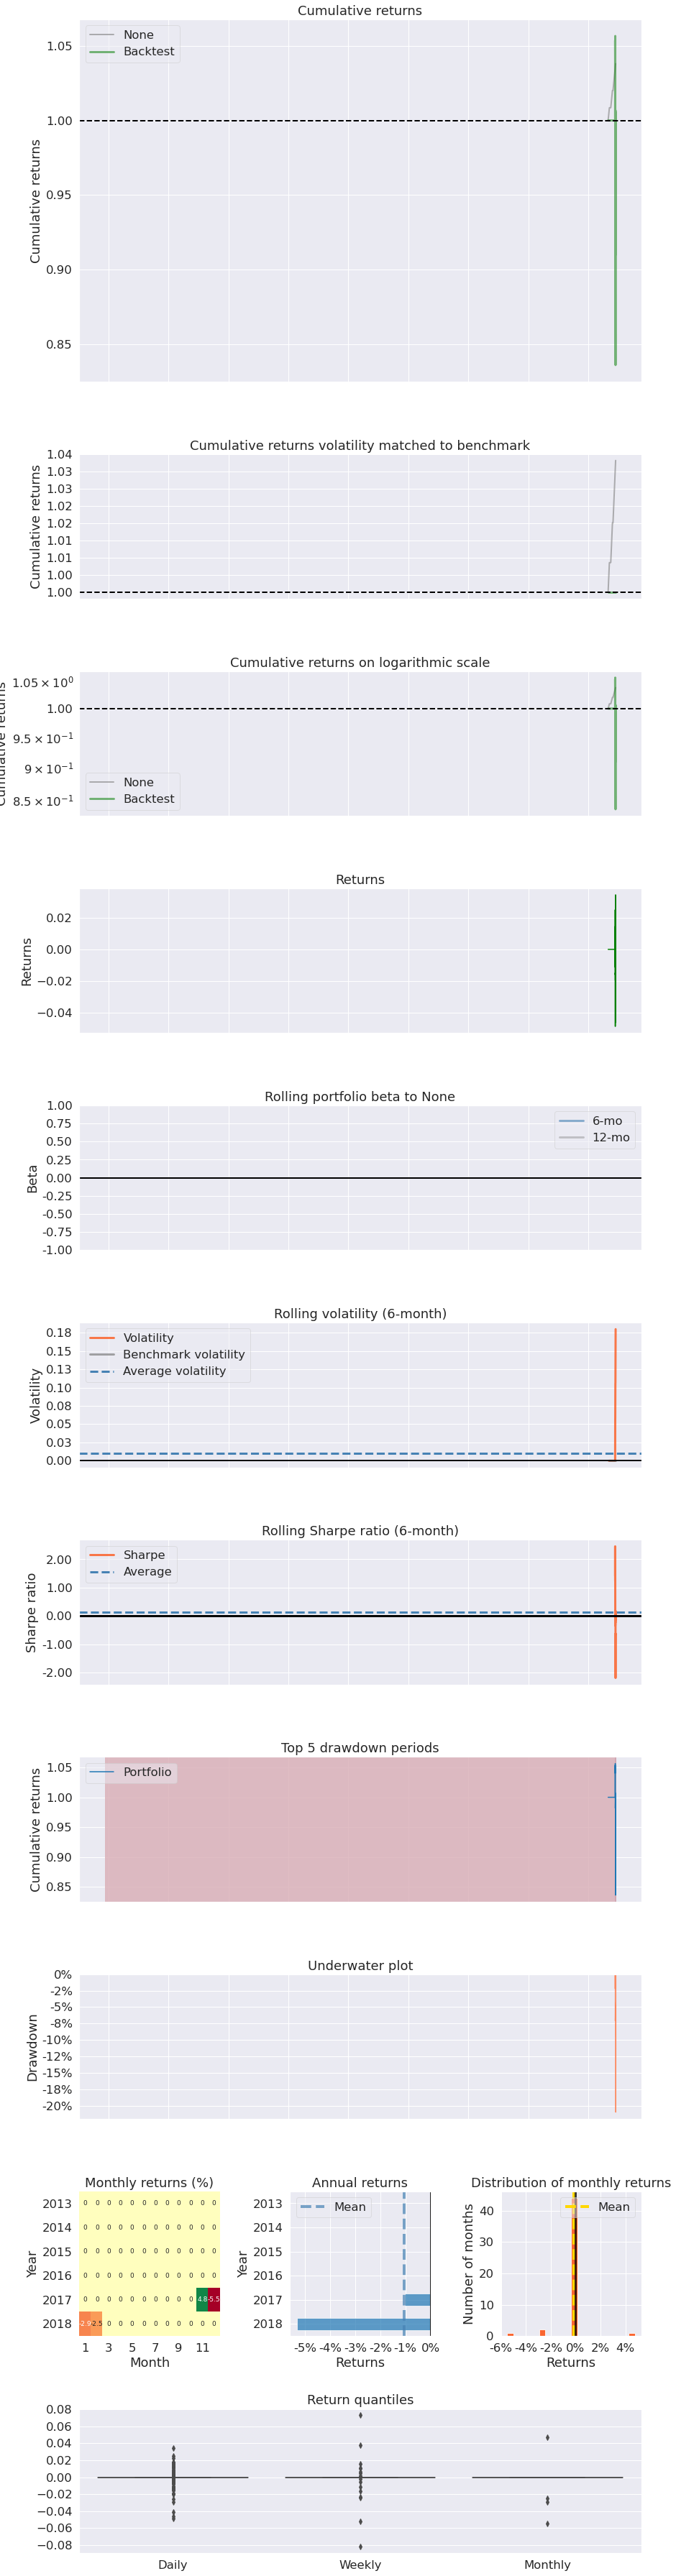

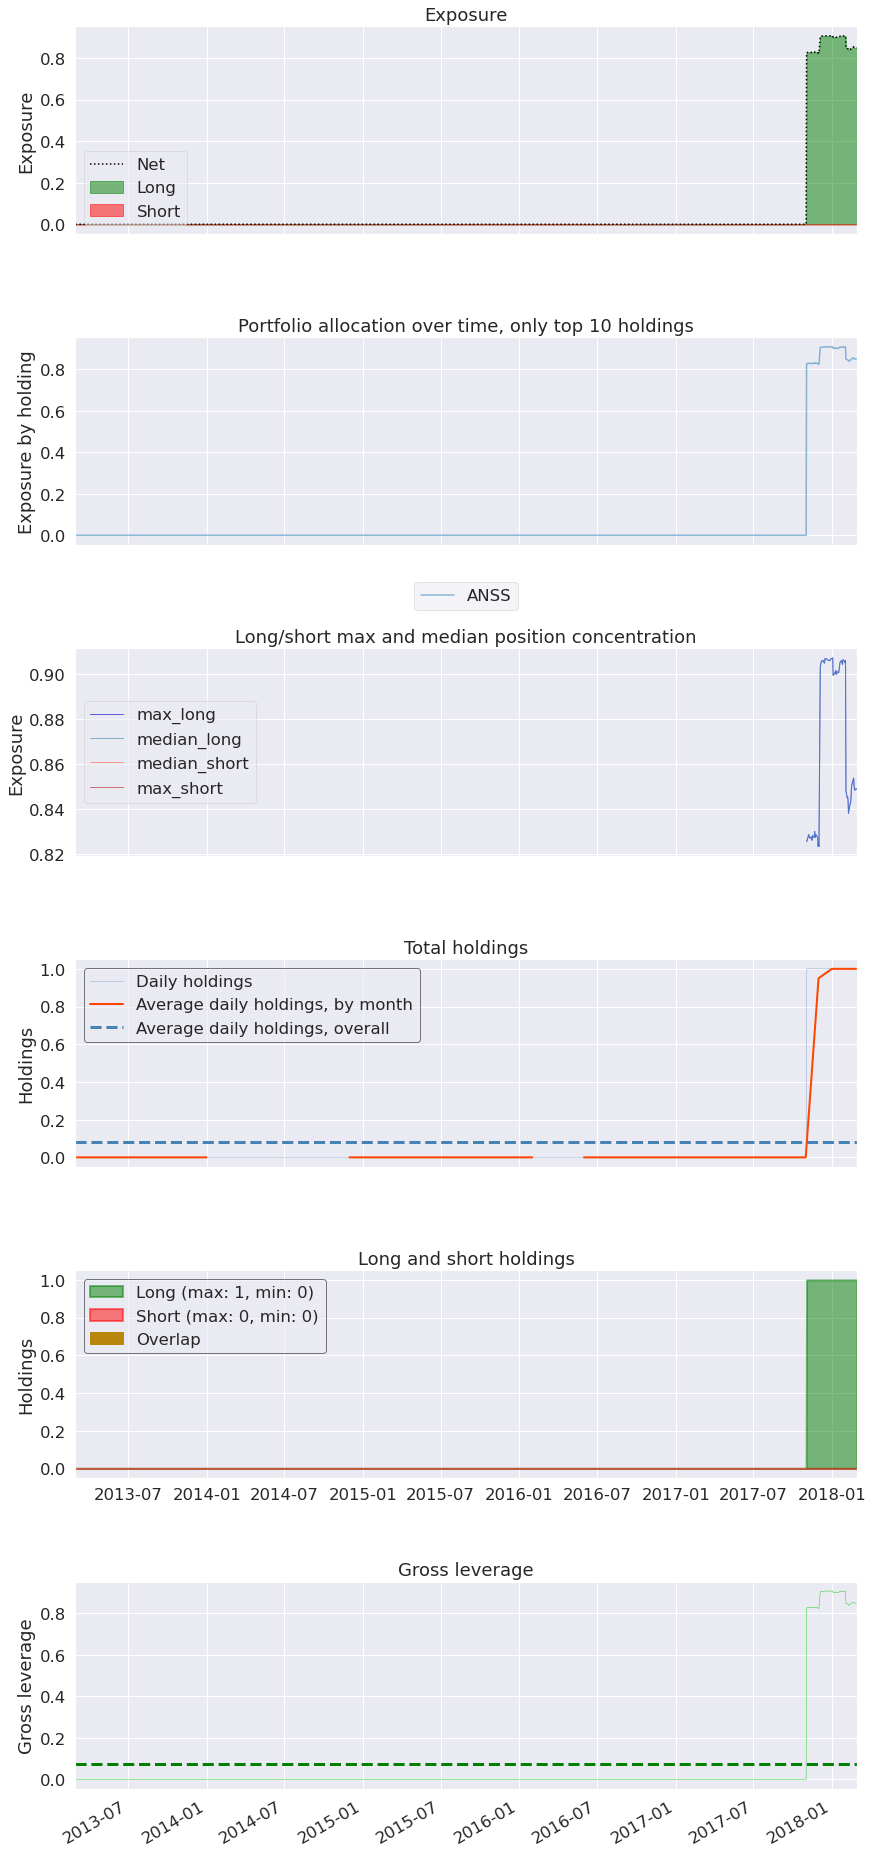

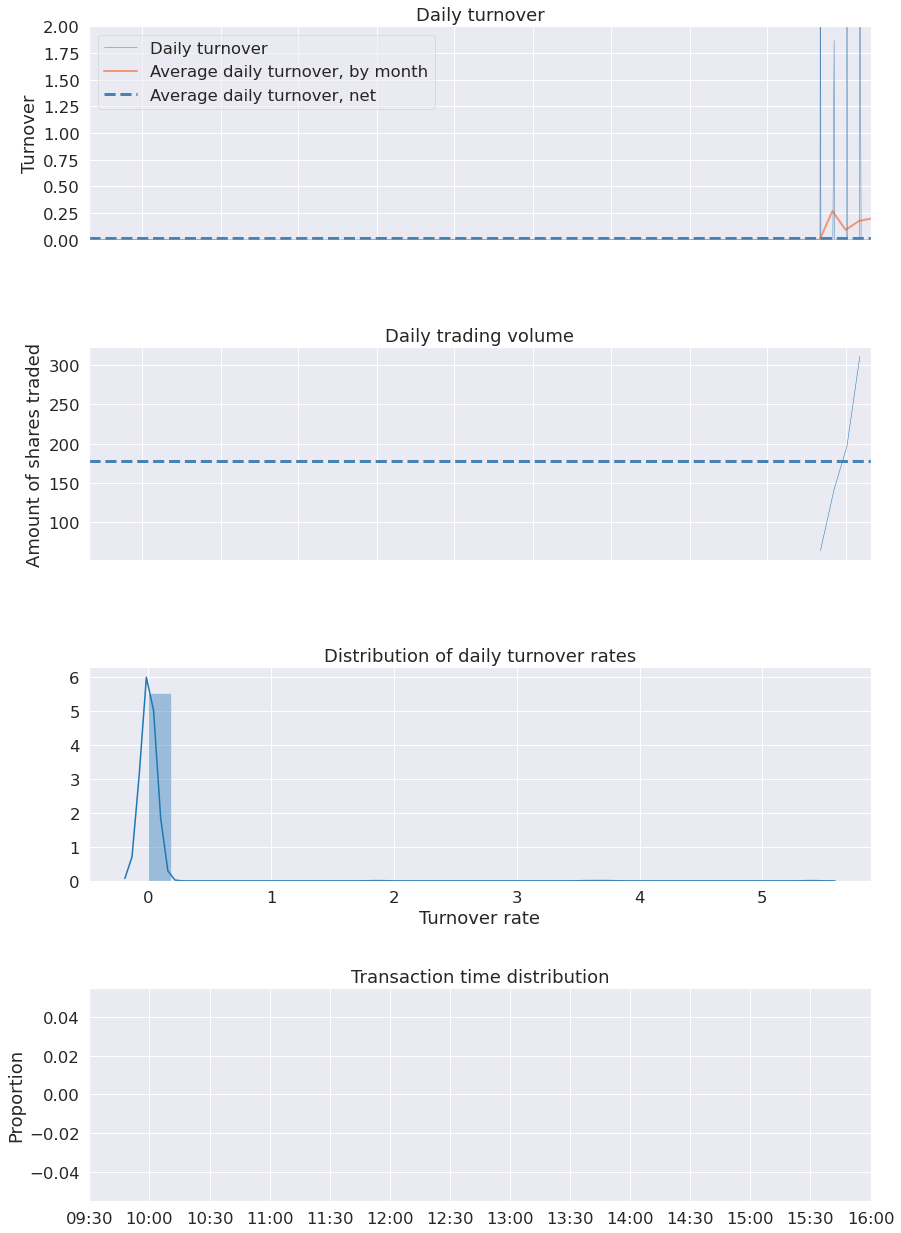

In [34]:
import datetime
import glob
import os.path
import pandas as pd
import backtrader as bt
import backtrader.analyzers as btanal
import pyfolio as pf
import numpy as np
from scipy.stats import linregress
import warnings 
warnings.filterwarnings('ignore')

globalparams = dict(cash=10000,            # if a different strategy is used
                    commission=0.005,                # how many chunks the data should have
                    )

def momentum_func(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized * (rvalue ** 2)

class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    #params = dict(period=50)
    func = momentum_func
   
class St(bt.Strategy):
    params = dict(
        selcperc=0.50,  # percentage of stocks to select from the universe
        rperiod=1,  # period for the returns calculation, default 1 period
        vperiod=30,  # lookback period for volatility - default 36 periods
        mperiod=30,  # lookback period for momentum - default 90 periods
        momentum=Momentum, # parametrize the momentum and its period
        reserve=0.05,  # 5% reserve capital
        monthdays=[1],
        monthcarry=True,
        when=bt.timer.SESSION_START

    )

    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))

    def __init__(self):
        # calculate 1st the amount of stocks that will be selected
        self.selnum = int(len(self.datas) * self.p.selcperc)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        self.perctarget = (1.0 - self.p.reserve) / self.selnum

        self.add_timer(
            when=self.p.when,
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )

        # returns, volatilities and momentums
        rs = [bt.ind.PctChange(d, period=self.p.rperiod) for d in self.datas]
        vs = [bt.ind.StdDev(ret, period=self.p.vperiod) for ret in rs]
        #ms = [bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas]
        ms = [self.p.momentum(d, period=self.p.mperiod) for d in self.datas]

        # simple rank formula: (momentum * net payout) / volatility
        # the highest ranked: low vol, large momentum, large payout
        self.ranks = {d: m / v for d, v, m in zip(self.datas, vs, ms)}
        #TODO: does it perform better without the volatility?
  
    def prenext(self):
        # call next() even when data is not available for all tickers
        self.next()     

    def notify_timer(self, timer, when, *args, **kwargs):
        print('strategy notify_timer with tid {}, when {} _getminperstatus {}'.
              format(timer.p.tid, when, int(self._getminperstatus())))
        if self._getminperstatus() < 0:
            
            self.rebalance()

    def next(self):
        pass
    def rebalance(self):

        # sort data and current rank
        ranks = sorted(
            self.ranks.items(),  # get the (d, rank), pair
            key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
            reverse=True,  # highest ranked 1st ... please
        )
        
        # put top ranked in dict with data as key to test for presence
        rtop = dict(ranks[:self.selnum])

        # For logging purposes of stocks leaving the portfolio
        rbot = dict(ranks[self.selnum:])

        # prepare quick lookup list of stocks currently holding a position
        posdata = [d for d, pos in self.getpositions().items() if pos]

        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)

        # rebalance those already top ranked and still there
        for d in (d for d in posdata if d in rtop):
            self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            del rtop[d]  # remove it, to simplify next iteration

        # issue a target order for the newly top ranked stocks
        # do this last, as this will generate buy orders consuming cash
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)


def run(args=None):
    cerebro = bt.Cerebro()


    # Parse from/to-date
    fromdate = datetime.datetime(2013, 3, 1)
    todate = datetime.datetime(2018, 6, 18)

    # add all the data files available in the directory datadir
    for fname in glob.glob(os.path.join(r'C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/data - Copy', '*')):
        df = pd.read_csv(fname, index_col=0, parse_dates=True)

        if len(df)>100:
            cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""), plot=False))
            print(fname)
            
    # add strategy
    cerebro.addstrategy(St)

    # set the cash
    cerebro.broker.setcash(globalparams["cash"])
    cerebro.broker.set_coc(True)
    cerebro.broker.setcommission(commission=globalparams["commission"])
    
    #Analysers such as Sharpe Ratio
    cerebro.addanalyzer(btanal.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(btanal.Returns)
    cerebro.addanalyzer(btanal.DrawDown)
    cerebro.addanalyzer(btanal.PyFolio)                # Needed to use PyFolio
    cerebro.addanalyzer(btanal.TradeAnalyzer)          # Analyzes individual trades
    cerebro.addanalyzer(btanal.SharpeRatio_A)          # Gets the annualized Sharpe ratio
    cerebro.addanalyzer(btanal.AnnualReturn)          # Annualized returns (does not work?)
    
    results = cerebro.run(stdstats=True, tradehistory=True)
    #cerebro.plot()
    #print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
    print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
    print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")

    # Basic performance evaluation ... final value ... minus starting cash
    pnl = cerebro.broker.get_value() - globalparams["cash"]
    print('Profit ... or Loss: {:.2f}'.format(pnl))
    
    
    returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
    benchmark_rets = pd.Series([0.00004] * len(returns.index), index=returns.index)     
    pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=benchmark_rets)
    
if __name__ == '__main__':
    run()